## Prepare Imports

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from fastai.vision import *
from fastai.metrics import error_rate

from pathlib import Path
import csv
import shutil
import os

In [3]:
path = Path('/home/fazzl/data/oxford-102-flowers')

In [4]:
path.ls()

[PosixPath('/home/fazzl/data/oxford-102-flowers/jpg'),
 PosixPath('/home/fazzl/data/oxford-102-flowers/train.txt'),
 PosixPath('/home/fazzl/data/oxford-102-flowers/valid.txt'),
 PosixPath('/home/fazzl/data/oxford-102-flowers/test.txt'),
 PosixPath('/home/fazzl/data/oxford-102-flowers/train'),
 PosixPath('/home/fazzl/data/oxford-102-flowers/labels.csv'),
 PosixPath('/home/fazzl/data/oxford-102-flowers/models'),
 PosixPath('/home/fazzl/data/oxford-102-flowers/valid'),
 PosixPath('/home/fazzl/data/oxford-102-flowers/labels_test.csv'),
 PosixPath('/home/fazzl/data/oxford-102-flowers/test')]

First, let's make folders so that we can have dataset as per [ImageDataBunch.from_csv()](https://docs.fast.ai/vision.data.html#ImageDataBunch.from_csv).

We will have to have structure like this:

```
path/
  /train
  /test
  labels.csv
```

In addition, `labels.csv` has to have structure like:

```
filename_1, category
filename_2, category
       ...,      ...
filename_n, category
```

**Note**: `test` parameter should be a folder of images. By default `labels.csv` will be used as train data with random split given by the parameter `valid_pct`. 

`folder` parameter is the root directory realtive to which paths in `labels.csv` will be loaded as data. By default it is `.` which is current directory.

In [5]:
path.ls()

[PosixPath('/home/fazzl/data/oxford-102-flowers/jpg'),
 PosixPath('/home/fazzl/data/oxford-102-flowers/train.txt'),
 PosixPath('/home/fazzl/data/oxford-102-flowers/valid.txt'),
 PosixPath('/home/fazzl/data/oxford-102-flowers/test.txt'),
 PosixPath('/home/fazzl/data/oxford-102-flowers/train'),
 PosixPath('/home/fazzl/data/oxford-102-flowers/labels.csv'),
 PosixPath('/home/fazzl/data/oxford-102-flowers/models'),
 PosixPath('/home/fazzl/data/oxford-102-flowers/valid'),
 PosixPath('/home/fazzl/data/oxford-102-flowers/labels_test.csv'),
 PosixPath('/home/fazzl/data/oxford-102-flowers/test')]

In [6]:
def prepare_data(path):
    labels_path = path/'labels.csv'
    labels_test_path = path/'labels_test.csv'
    train_path = path/'train'
    test_path = path/'test'
    
    # Clean up after last run
    if labels_path.exists():
        os.remove(str(labels_path))
        print("Removed existing labels.csv")
    
    if labels_test_path.exists():
        os.remove(str(labels_test_path))
        print("Removed existing labels_test.csv")
        
    if train_path.exists():
        shutil.rmtree(path/'train')
        print("Removed existing train folder.")
        
    if test_path.exists():    
        shutil.rmtree(path/'test')
        print("Removed existing test folder.")
        
    # Do actual preparation
    for t in ['train','valid']:
        copy_files_make_csv(t, path, 'labels.csv')
        
    # Prepare the test folder
    copy_files_make_csv('test', path, 'labels_test.csv')

def copy_files_make_csv(t, p, csv_name):
    if t not in ['train', 'test', 'valid']:
        raise ValueError("Argument must be either 'train' or 'test'")
    labels_path = p / (t + '.txt')
    fastai_labels = p / csv_name
    
    with open(fastai_labels, 'a') as labels:
        with open(labels_path) as f:
            for line in f:
                    jpg_filename, category = line.strip('\n').split(' ')
                    jpg = jpg_filename[:4]
                    filename = jpg_filename[4:]
                    target_path = str(p) + '/' + t + '/' + filename

                    if not os.path.exists(os.path.dirname(target_path)):
                        os.makedirs(os.path.dirname(target_path))
                        print(f'Created new dir: {os.path.dirname(target_path)}')

                    src = str(p/jpg/filename)
                    dst = str(p/target_path)
                    
#                     print(src + ' -> ' + dst)

                    shutil.copy2(src, dst)
                    labels.write(t + '/' + filename + ',' + category + '\n')
                
    print(labels_path)

In [7]:
prepare_data(path)

Removed existing labels.csv
Removed existing labels_test.csv
Removed existing train folder.
Removed existing test folder.
Created new dir: /home/fazzl/data/oxford-102-flowers/train
/home/fazzl/data/oxford-102-flowers/train.txt
/home/fazzl/data/oxford-102-flowers/valid.txt
Created new dir: /home/fazzl/data/oxford-102-flowers/test
/home/fazzl/data/oxford-102-flowers/test.txt


In [12]:
path.ls()

[PosixPath('/home/fazzl/data/oxford-102-flowers/jpg'),
 PosixPath('/home/fazzl/data/oxford-102-flowers/train.txt'),
 PosixPath('/home/fazzl/data/oxford-102-flowers/valid.txt'),
 PosixPath('/home/fazzl/data/oxford-102-flowers/test.txt'),
 PosixPath('/home/fazzl/data/oxford-102-flowers/train'),
 PosixPath('/home/fazzl/data/oxford-102-flowers/labels.csv'),
 PosixPath('/home/fazzl/data/oxford-102-flowers/models'),
 PosixPath('/home/fazzl/data/oxford-102-flowers/valid'),
 PosixPath('/home/fazzl/data/oxford-102-flowers/labels_test.csv'),
 PosixPath('/home/fazzl/data/oxford-102-flowers/test')]

Now that the data is prepared, let's try and see what we got.

## Making the dataset

In [9]:
path # where the required structure for `.from_csv`
path_test = path / 'test'
print(path, path_test)

/home/fazzl/data/oxford-102-flowers /home/fazzl/data/oxford-102-flowers/test


In [10]:
bs=64
tfms = get_transforms()
data = ImageDataBunch.from_csv(path, size=224, ds_tfms=tfms, bs=bs, test=path_test).normalize(imagenet_stats)

In [13]:
len(data.train_ds) + len(data.valid_ds)

2039

In [17]:
len(data.test_ds)

6149

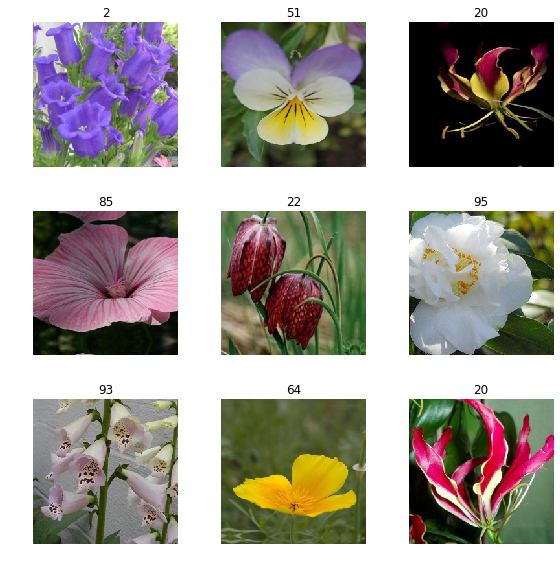

In [18]:
data.show_batch(rows=3, figsize=(8,8))

In [19]:
len(data.classes)

102

## Train ResNet50

In [20]:
learn = create_cnn(data, models.resnet50, metrics=error_rate)

In [21]:
learn.fit_one_cycle(4)

Total time: 00:43
epoch  train_loss  valid_loss  error_rate
1      3.712265    1.705477    0.327670    (00:13)
2      2.085375    0.734237    0.167476    (00:09)
3      1.231282    0.569572    0.135922    (00:09)
4      0.790649    0.555686    0.118932    (00:09)



So far so good! Let's see interpretations.

In [22]:
interp = ClassificationInterpretation.from_learner(learn)

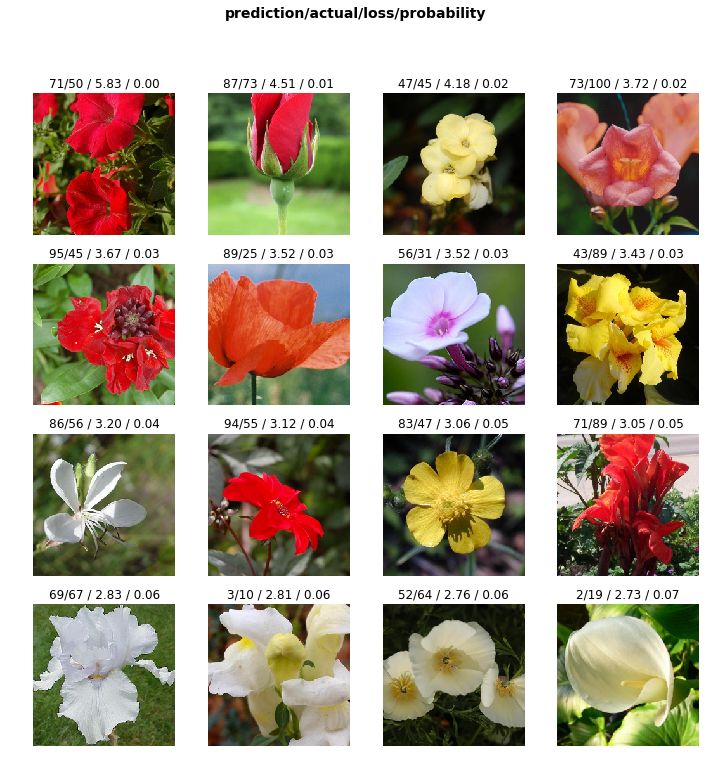

In [23]:
interp.plot_top_losses(16, figsize=(12,12))

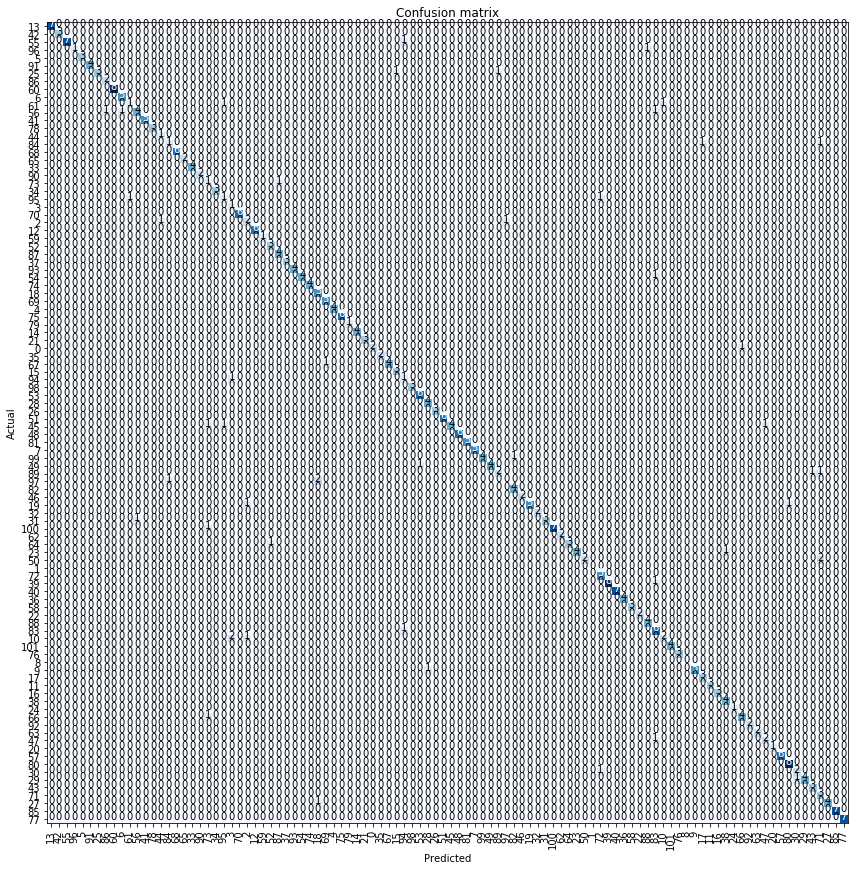

In [24]:
interp.plot_confusion_matrix(figsize=(12,12))

In [25]:
interp.most_confused()

[(97, 18, 2), (50, 71, 2), (10, 3, 2)]

In [26]:
learn.save('resnet50-stage-01')

## Unfreezing and Finetuning

In [27]:
learn.unfreeze()
learn.fit_one_cycle(1)

Total time: 00:12
epoch  train_loss  valid_loss  error_rate
1      1.303150    1.825735    0.453883    (00:12)



In [28]:
data.train_ds

DatasetTfm(ImageClassificationDataset of len 1627)

In [29]:
data.valid_ds

DatasetTfm(ImageClassificationDataset of len 412)

In [30]:
data.test_ds

DatasetTfm(ImageClassificationDataset of len 6149)

In [31]:
learn.load('resnet50-stage-01')

In [32]:
learn.lr_find(start_lr=1e-09, end_lr=1, num_it=200)

LR Finder complete, type {learner_name}.recorder.plot() to see the graph.


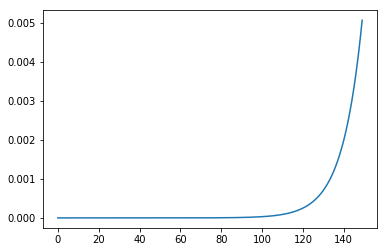

In [33]:
learn.recorder.plot_lr()

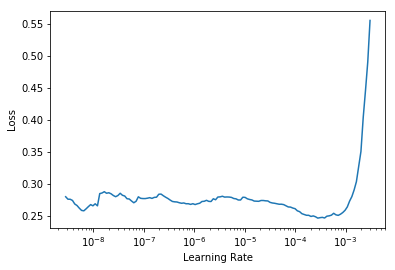

In [34]:
learn.recorder.plot()

In [35]:
learn.unfreeze()
learn.fit_one_cycle(2, max_lr=slice(1e-6,5e-4))

Total time: 00:23
epoch  train_loss  valid_loss  error_rate
1      0.255175    0.505576    0.121359    (00:11)
2      0.212951    0.462048    0.104369    (00:11)



In [36]:
learn.save('resnet50-stage-02')

In [40]:
learn.fit_one_cycle(4, max_lr=slice(1e-6,5e-4))

Total time: 00:46
epoch  train_loss  valid_loss  error_rate
1      0.169610    0.428941    0.097087    (00:11)
2      0.141856    0.407937    0.094660    (00:11)
3      0.118228    0.366514    0.089806    (00:11)
4      0.101255    0.358577    0.080097    (00:11)



In [41]:
learn.save('resnet50-stage-03')

In [42]:
learn.fit_one_cycle(4, max_lr=slice(1e-6,5e-4))

Total time: 00:47
epoch  train_loss  valid_loss  error_rate
1      0.072967    0.352281    0.080097    (00:11)
2      0.068525    0.332759    0.084951    (00:11)
3      0.058541    0.315921    0.082524    (00:11)
4      0.048384    0.314680    0.080097    (00:11)



We have signs of overfitting here, so let's go back to the last saved model.

In [87]:
learn.load('resnet50-stage-03')